# Individual Project - Kickstarters

## Pre-processing

In [1]:
# Import libraries
import pandas as pd
#!pip install category_encoders
import category_encoders as ce
import numpy as np
from numpy import where
from sklearn.ensemble import IsolationForest
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Read the file
df = pd.read_excel("Kickstarter.xlsx")
print('Dataset shape:', df.shape)

Dataset shape: (15474, 45)


In [3]:
# Create the "goal_usd" column
df['goal_usd'] = df['goal'] * df['static_usd_rate']

# Identify only the relevant variables
variables = ['state', 'category', 'name_len', 'blurb_len', 'create_to_launch_days', 'launch_to_deadline_days', 'goal_usd']
new_df = df[variables]

# Only going to predict "successful" or "failed" projects
new_df = new_df[(new_df.state == "successful") | (new_df.state == "failed")]

# Assign "none" to the null categories
new_df['category'].fillna('Others', inplace=True)

# Drop duplicates
new_df = new_df.drop_duplicates()

# Drop rows with missing values
new_df = new_df.dropna()

# Encode the target variable
new_df['state'] = new_df['state'].replace({'successful': 1, 'failed': 0})

# Dummify categorical variable
new_df = pd.get_dummies(new_df, columns = ['category'])

print('Dataset shape:', new_df.shape)
new_df.head()

Dataset shape: (13429, 29)


,state,name_len,blurb_len,create_to_launch_days,launch_to_deadline_days,goal_usd,category_Academic,category_Apps,category_Blues,category_Experimental,...,category_Plays,category_Robots,category_Shorts,category_Software,category_Sound,category_Spaces,category_Thrillers,category_Wearables,category_Web,category_Webseries
0,0,8.0,18.0,62,30,21449.83740,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,9.0,23.0,9,45,10034.45163,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,6.0,19.0,1,14,2000.00000,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,1,6.0,19.0,21,60,3000.00000,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
6,0,2.0,20.0,23,37,35000.00000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## EDA

In [4]:
# Build isolation forest model to remove outliers
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso_forest.fit(new_df)

outliers = iso_forest.predict(new_df)

# Select all rows that are not outliers
clean_df = new_df[outliers != -1]

print('Dataset shape:', clean_df.shape)
clean_df.head()

Dataset shape: (12757, 29)


,state,name_len,blurb_len,create_to_launch_days,launch_to_deadline_days,goal_usd,category_Academic,category_Apps,category_Blues,category_Experimental,...,category_Plays,category_Robots,category_Shorts,category_Software,category_Sound,category_Spaces,category_Thrillers,category_Wearables,category_Web,category_Webseries
0,0,8.0,18.0,62,30,21449.83740,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,9.0,23.0,9,45,10034.45163,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,6.0,19.0,1,14,2000.00000,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,1,6.0,19.0,21,60,3000.00000,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
6,0,2.0,20.0,23,37,35000.00000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

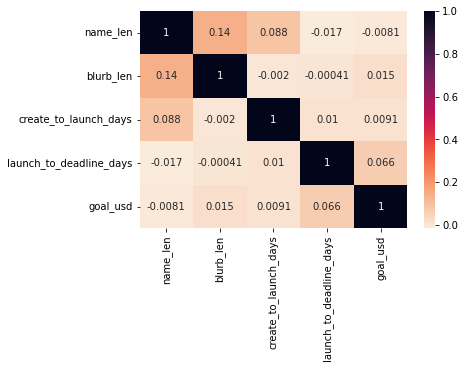

In [5]:
# Obtain correlation matrix for numerical values
numeric = ['name_len', 'blurb_len', 'create_to_launch_days', 'launch_to_deadline_days', 'goal_usd']

c= clean_df[numeric].corr()
sns.heatmap(c,cmap="rocket_r",annot=True)

In [6]:
# Detecting multicollinearity
# Create VIF dataframe
vif = add_constant(clean_df[numeric])
vif_data = pd.DataFrame()
vif_data["feature"] = vif.columns

# Calculating VIF for each feature
for i in range(len(vif.columns)):
    vif_data.loc[vif_data.index[i],"VIF"] = variance_inflation_factor(vif.values, i)

print(vif_data)

                   feature        VIF
0                    const  31.387705
1                 name_len   1.028882
2                blurb_len   1.020723
3    create_to_launch_days   1.008305
4  launch_to_deadline_days   1.004710
5                 goal_usd   1.004729


## Classification Model

In [7]:
# Import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV

In [8]:
# Determine the predictors 'X' and target variable 'y'
X = clean_df.drop(['state'], axis=1)
y = clean_df['state']

# Split the data in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)

# Standardize the numerical values
scaler = StandardScaler()

X_train[numeric] = scaler.fit_transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

In [9]:
# Define the models
models = {
    "RandomForest": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "GradientBoosting": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier(),
    "NeuralNetwork": MLPClassifier(hidden_layer_sizes=(16), max_iter=1000)}

# Train and evaluate each model
model_scores = {}
for name, model in models.items():
    
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store scores
    model_scores[name] = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}
    
# Display model performance
for model, scores in model_scores.items():
    print(f"Model: {model}")
    for score_name, score_value in scores.items():
        print(f"{score_name}: {score_value:.4f}")
    print("\n")

Model: RandomForest
Accuracy: 0.7325
Precision: 0.6255
Recall: 0.4953
F1 Score: 0.5528


Model: LogisticRegression
Accuracy: 0.7194
Precision: 0.6106
Recall: 0.4405
F1 Score: 0.5118


Model: GradientBoosting
Accuracy: 0.7471
Precision: 0.6649
Recall: 0.4890
F1 Score: 0.5636


Model: KNN
Accuracy: 0.6808
Precision: 0.5257
Recall: 0.4484
F1 Score: 0.4840


Model: NeuralNetwork
Accuracy: 0.7322
Precision: 0.6186
Recall: 0.5164
F1 Score: 0.5629




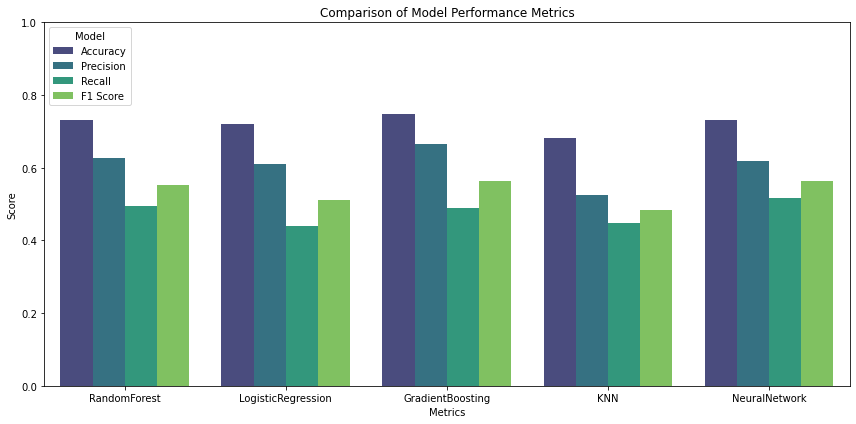

In [10]:
# Convert the model_scores dictionary to a DataFrame for plotting
scores_df = pd.DataFrame(model_scores).T

melted_scores_df = scores_df.reset_index().melt(id_vars='index')
melted_scores_df.columns = ['Metric', 'Model', 'Score']

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=melted_scores_df, palette="viridis")
plt.title("Comparison of Model Performance Metrics")
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.ylim(0, 1) 
plt.legend(title='Model', loc='upper left')
plt.tight_layout()

plt.show()

In [11]:
'''# Conduct hyperparameter tuning for the GradientBoosting Model (model with highest accuracy)
param_grid = {
    'n_estimators': [100, 150, 200],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.1, 0.2]}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=GradientBoostingClassifier(random_state=5),
                           param_grid=param_grid, cv=5, verbose=True)

# Fit to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)'''

'# Conduct hyperparameter tuning for the GradientBoosting Model (model with highest accuracy)\nparam_grid = {\n    \'n_estimators\': [100, 150, 200],\n    \'min_samples_split\': [2, 3, 4],\n    \'min_samples_leaf\': [1, 2, 3],\n    \'max_depth\': [2, 3, 4],\n    \'learning_rate\': [0.01, 0.1, 0.2]}\n\n# Initialize the GridSearchCV object\ngrid_search = GridSearchCV(estimator=GradientBoostingClassifier(random_state=5),\n                           param_grid=param_grid, cv=5, verbose=True)\n\n# Fit to the training data\ngrid_search.fit(X_train, y_train)\n\n# Print the best parameters\nprint("Best Parameters:", grid_search.best_params_)'

In [12]:
# Run the Gradient Boosting model with the best parameters
best_model = GradientBoostingClassifier(max_depth=3, min_samples_split=4, n_estimators=150, 
                                        learning_rate=0.1, min_samples_leaf=1)

# Train the model
best_model.fit(X_train, y_train)

# Make predictions
y_pred = best_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.7484326018808778
Precision: 0.6598984771573604
Recall: 0.5086071987480438
F1 Score: 0.5744586831639417


## GRADING - Classification Model

In [13]:
# Read the file
df_grade = pd.read_excel("Kickstarter-Grading.xlsx")

# Create the "goal_usd" column
df_grade['goal_usd'] = df_grade['goal'] * df_grade['static_usd_rate']

# Identify only the relevant variables
variables = ['state', 'category', 'name_len', 'blurb_len', 'create_to_launch_days', 'launch_to_deadline_days', 'goal_usd']
new_df_grade = df_grade[variables]

# Only going to predict "successful" or "failed" projects
new_df_grade = new_df_grade[(new_df_grade.state == "successful") | (new_df_grade.state == "failed")]

# Assign "none" to the null categories
new_df_grade['category'].fillna('Others', inplace=True)

# Drop rows with missing values
new_df_grade = new_df_grade.dropna()

# Encode the target variable
new_df_grade['state'] = new_df_grade['state'].replace({'successful': 1, 'failed': 0})

# Dummify categorical variable
new_df_grade = pd.get_dummies(new_df_grade, columns = ['category'])

# Determine the predictors 'X' and target variable 'y'
X_grade = new_df_grade.drop(['state'], axis=1)
y_grade = new_df_grade['state']

# Standardize the numerical values
scaler = StandardScaler()
numeric = ['name_len', 'blurb_len', 'create_to_launch_days', 'launch_to_deadline_days', 'goal_usd']

X_grade[numeric] = scaler.fit_transform(X_grade[numeric])

# Apply the model previously trained to the grading data
y_grading_pred = best_model.predict(X_grade)

# Calculate metrics
accuracy = accuracy_score(y_grade, y_grading_pred)
precision = precision_score(y_grade, y_grading_pred)
recall = recall_score(y_grade, y_grading_pred)
f1 = f1_score(y_grade, y_grading_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.6794285714285714
Precision: 0.6424870466321243
Recall: 0.2012987012987013
F1 Score: 0.3065512978986403


In [14]:
# Let's try the other models
models = {
    "RandomForest": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "GradientBoosting": GradientBoostingClassifier(), # without hyperparameter tuning
    "KNN": KNeighborsClassifier(),
    "NeuralNetwork": MLPClassifier(hidden_layer_sizes=(16), max_iter=1000)}

# Train and evaluate each model
model_scores = {}
for name, model in models.items():
    
    # Train the model (using the original dataset)
    model.fit(X_train, y_train)

    # Make predictions
    y_grading_pred = model.predict(X_grade)

    # Calculate metrics
    accuracy = accuracy_score(y_grade, y_grading_pred)
    precision = precision_score(y_grade, y_grading_pred)
    recall = recall_score(y_grade, y_grading_pred)
    f1 = f1_score(y_grade, y_grading_pred)

    # Store scores
    model_scores[name] = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}
    
# Display model performance
for model, scores in model_scores.items():
    print(f"Model: {model}")
    for score_name, score_value in scores.items():
        print(f"{score_name}: {score_value:.4f}")
    print("\n")

Model: RandomForest
Accuracy: 0.6606
Precision: 0.5414
Recall: 0.2338
F1 Score: 0.3265


Model: LogisticRegression
Accuracy: 0.7206
Precision: 0.6608
Recall: 0.4237
F1 Score: 0.5163


Model: GradientBoosting
Accuracy: 0.6686
Precision: 0.6385
Recall: 0.1347
F1 Score: 0.2225


Model: KNN
Accuracy: 0.6789
Precision: 0.5469
Recall: 0.5114
F1 Score: 0.5285


Model: NeuralNetwork
Accuracy: 0.6897
Precision: 0.6272
Recall: 0.2922
F1 Score: 0.3987




## Clustering Model

In [15]:
# Import libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [16]:
# Create the "goal_usd" column
df['goal_usd'] = df['goal'] * df['static_usd_rate']

# Assign "none" to the null categories
df['category'].fillna('Others', inplace=True)

# Find categories with a count less than 500 and add these categories with 'Others' in the DataFrame
category_counts = df['category'].value_counts()
small_categories = category_counts[category_counts < 500].index.tolist()

df['subgroup'] = df['category'].apply(lambda x: 'Others' if x in small_categories else x)

# Identify only the relevant variables
variables = ['state', 'country', 'subgroup', 'goal_usd']
new_df = df[variables]

# Only going to predict "successful" or "failed" projects
new_df = new_df[(new_df.state == "successful") | (new_df.state == "failed")]

# Drop rows with missing values
new_df = new_df.dropna()

# Encode the state variable
new_df['state'] = new_df['state'].replace({'successful': 1, 'failed': 0})

# Label all countries that are not "US" as 0
new_df['country'] = new_df['country'].apply(lambda x: 0 if x != 'US' else 1)

# Dummify categorical variable
new_df = pd.get_dummies(new_df, columns = ['subgroup'])

print('Dataset shape:', new_df.shape)
new_df.head()

Dataset shape: (13435, 12)


,state,country,goal_usd,subgroup_Apps,subgroup_Gadgets,subgroup_Hardware,subgroup_Musical,subgroup_Others,subgroup_Plays,subgroup_Software,subgroup_Wearables,subgroup_Web
0,0,0,21449.83740,0,1,0,0,0,0,0,0,0
1,1,0,10034.45163,0,0,0,0,1,0,0,0,0
4,1,1,2000.00000,0,0,0,0,1,0,0,0,0
5,1,1,3000.00000,0,0,0,0,0,1,0,0,0
6,0,1,35000.00000,0,1,0,0,0,0,0,0,0


In [17]:
# Build isolation forest model to remove outliers
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso_forest.fit(new_df)

outliers = iso_forest.predict(new_df)

# Select all rows that are not outliers
clean_df = new_df[outliers != -1]

print('Dataset shape:', clean_df.shape)
clean_df.head()

Dataset shape: (12764, 12)


,state,country,goal_usd,subgroup_Apps,subgroup_Gadgets,subgroup_Hardware,subgroup_Musical,subgroup_Others,subgroup_Plays,subgroup_Software,subgroup_Wearables,subgroup_Web
0,0,0,21449.83740,0,1,0,0,0,0,0,0,0
1,1,0,10034.45163,0,0,0,0,1,0,0,0,0
4,1,1,2000.00000,0,0,0,0,1,0,0,0,0
5,1,1,3000.00000,0,0,0,0,0,1,0,0,0
6,0,1,35000.00000,0,1,0,0,0,0,0,0,0


In [18]:
# Standardize the numerical value
scaler = StandardScaler()
numeric = ['goal_usd']

std_df = clean_df.copy(deep=True)
std_df[numeric] = scaler.fit_transform(std_df[numeric])

C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_

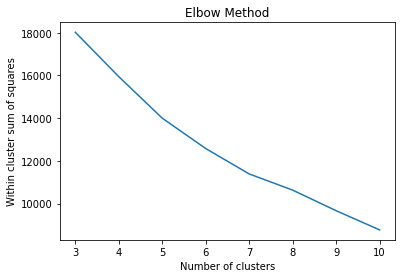

In [19]:
# Determine the number of clusters using the elbow method
withinss = []
for i in range (3,11):    
    kmeans = KMeans(n_clusters = i, init='k-means++', random_state=5)
    model = kmeans.fit(std_df)
    withinss.append(model.inertia_)
    
# Create a plot
plt.plot(range(3,11), withinss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within cluster sum of squares')
plt.show()

C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_

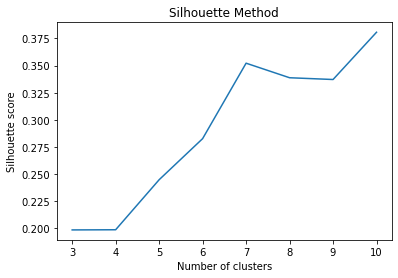

In [20]:
# Determine the number of clusters using the Silhouette method
silhouette = []
for i in range(3, 11):    
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=5)
    model = kmeans.fit(std_df)
    labels = model.labels_
    silhouette.append(silhouette_score(std_df, labels))
    
# Create a plot
plt.plot(range(3, 11), silhouette)
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


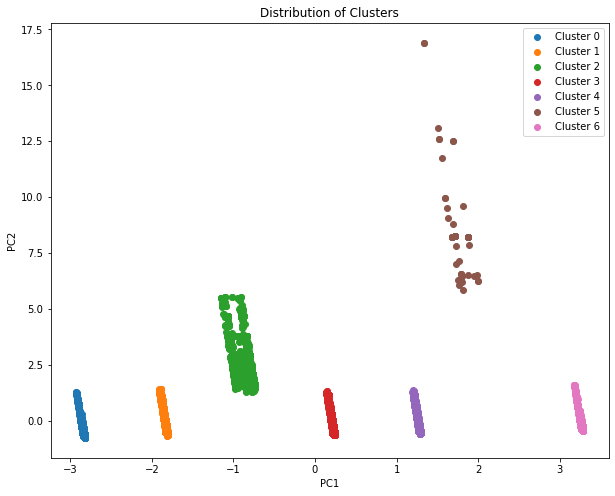

In [21]:
# Run model with the optimal number of clusters
kmeans = KMeans(n_clusters = 7, init='k-means++', random_state=5)
model = kmeans.fit(std_df)
labels = model.predict(std_df)

std_df['Cluster'] = labels

# Perform PCA to reduce the data to 2 dimensions
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(std_df)

pca_df = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

pca_df['Cluster'] = labels

# Plot the clusters
plt.figure(figsize=(10, 8))
for i in range(kmeans.n_clusters):
    cluster_data = pca_df[pca_df['Cluster'] == i]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {i}')
plt.title('Distribution of Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

In [22]:
# Create a new column for the cluster category
clean_df['Cluster'] = labels

# Obtain the summary of each cluster
print(clean_df['Cluster'].value_counts(), '\n')

for column in new_df.columns:
    if column != 'Cluster':  
        print(f"Descriptive Statistics for: {column}")
        print(clean_df.groupby('Cluster')[column].describe().T)
        print("\n") 

C:\Users\user\AppData\Local\Temp\ipykernel_15500\1525651874.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['Cluster'] = labels


3    3289
4    3034
1    2087
0    1973
6    1664
2     662
5      55
Name: Cluster, dtype: int64 

Descriptive Statistics for: state
Cluster            0            1           2            3            4  \
count    1973.000000  2087.000000  662.000000  3289.000000  3034.000000   
mean        0.090725     0.422616    0.101208     0.421709     0.496045   
std         0.287290     0.494094    0.301833     0.493908     0.500067   
min         0.000000     0.000000    0.000000     0.000000     0.000000   
25%         0.000000     0.000000    0.000000     0.000000     0.000000   
50%         0.000000     0.000000    0.000000     0.000000     0.000000   
75%         0.000000     1.000000    0.000000     1.000000     1.000000   
max         1.000000     1.000000    1.000000     1.000000     1.000000   

Cluster          5            6  
count    55.000000  1664.000000  
mean      0.036364     0.167668  
std       0.188919     0.373684  
min       0.000000     0.000000  
25%       0.000000  